In [1]:
from __future__ import division

import random
import math
import csv
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer
import argparse
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torchsummary import summary 

# from torch.utils.tensorboard import SummaryWriter

## PSO 

In [2]:
# @torch.no_grad()
def AuxLoss(x):
    with torch.no_grad():

        global H_net1
        global H_net2
        global H_net3


        loss = 0

        x = x.float().cuda().detach()  

        C = x.shape[1] 
        if C == 16:          #Channel sizes
            H_net = H_net1
        elif C == 32:
            H_net = H_net2
        elif C == 64:
            H_net = H_net3

        loss = H_net(x)
        fitness = 1 - loss


        return fitness

In [4]:
# @torch.no_grad()
def update_velocity(position_i, pos_best_g, pos_best_i, velocity_i):
    with torch.no_grad():
        
        P = position_i.shape[1]

        w = 1                 #inertia weight (how much to weigh the previous velocity)
        c1 = 2.05             # cognative constant
        c2 = 2.05             # social constant

        r1=random.gauss(1.1, 0.01)    
        r2=random.gauss(1.1, 0.01)
        
        c = c1*r1 + c2*r2  
        denominator = 2 - c - np.sqrt(c*(c-4))
        k=0.5
        Chi = 2*k/(np.absolute(denominator))
        if np.isnan(Chi):
            Chi = 0.729


        return Chi*( w*velocity_i + 
                     c1*r1*(pos_best_i - position_i) + 
                     c2*r2*(pos_best_g - position_i) 
                   )

In [5]:
# @torch.no_grad()
def EvaluateSwarm(costFunc, x, StaleFitness, SwarmOwnBest):
    with torch.no_grad():
    
        P = x.shape[1]
        fitnessMatrix = []

        for i in range(P):
            particle = x[:,i,:,:,:]
            fitnessMatrix.append(costFunc(particle))
        NewfitTensor = torch.cat(fitnessMatrix,1)                       #(B,P)  :Fitness for each particle     


        for i in range(x.shape[0]):                                     #B
            for j in range(x.shape[1]):                                 #P
                if NewfitTensor[i][j] < StaleFitness[i][j]:
                    SwarmOwnBest[i,j] = x[i,j]

        StaleFitness = torch.where(StaleFitness<NewfitTensor , StaleFitness, NewfitTensor)

        return StaleFitness, SwarmOwnBest

In [6]:
# @torch.no_grad()
def globalBestPositionAndError(gbfit, gbpos, swarmfit=None, swarmpos=None):
    with torch.no_grad():


        if swarmfit==None and swarmpos==None:
            fit = gbfit
            pos = gbpos
        else:    

            fit = torch.cat([gbfit,swarmfit], 1)                            #B,1+P 
            pos = torch.cat([gbpos.unsqueeze(1),swarmpos], 1)               #B,1+P,C,H,W

        gbfit, index = torch.min(fit,1)

        l =[]
        for i,ele in enumerate(index):
            l.append(pos[i, ele ,:,:,:].unsqueeze(0))

    #     gbpos = torch.cat(l)

        return gbfit.unsqueeze(1), torch.cat(l)

In [7]:
# @torch.no_grad()
class PSO:
    def __init__(self):     
        self.gbPos = None                      #(B,C,H,W)
        self.gbError = -1                      #(B,1)
        self.SwarmFitness = 0.0                #(B,P)
        self.SwarmPastOwnBest = None           #(B,P,C,H,W)
        self.LastVelocity = None               #(B,P,C,H,W) 
        self.swarm = []                        #(B,P,C,H,W)
        self.averageSwarmFitness = []
        self.averageMovement = []
        
#     @torch.no_grad()
    def run(self, x, costFunc, num_particles=5, maxiter=3 ):                  #x - (B,P,C,H,W)
        with torch.no_grad():
        
                
            #Intialisation        
            if x.shape[1] < num_particles:
                self.swarm = x.repeat(1,int(num_particles/x.shape[1]), 1,1,1)
            else:
                self.swarm = x

            B = self.swarm.shape[0]        
            P = self.swarm.shape[1]

            j=0
            while j < maxiter:            

                #On a just initialised swarm.
                if isinstance(self.gbError, int) and self.gbError == -1:

                    self.SwarmFitness, self.SwarmPastOwnBest = EvaluateSwarm(costFunc, 
                                                                             self.swarm, 
                                                                             torch.ones((B,P), device='cuda'),    #Works becuase sigmoid output is in [0,1]
                                                                             self.swarm)

                    self.gbError, self.gbPos = globalBestPositionAndError( self.SwarmFitness, 
                                                                           self.SwarmPastOwnBest )

                    self.LastVelocity = torch.zeros(self.swarm.shape, device='cuda')

                else:
                    #Step 1.a: Evaluate Particles
                    self.SwarmFitness, self.SwarmPastOwnBest = EvaluateSwarm(costFunc, 
                                                                             self.swarm, 
                                                                             self.SwarmFitness, 
                                                                             self.SwarmPastOwnBest)


                    #Step 1.b: determine if current particles are the best (globally)
                    self.gbError, self.gbPos = globalBestPositionAndError( self.gbError, 
                                                                           self.gbPos,
                                                                           self.SwarmFitness, 
                                                                           self.SwarmPastOwnBest )


                    #Step 2: Swarm Updates a.velocities and b.position
                    self.LastVelocity = update_velocity(self.swarm, 
                                                 self.gbPos.unsqueeze(1).repeat((1,P,1,1,1)), 
                                                 self.SwarmPastOwnBest, 
                                                 self.LastVelocity)                 

                    self.swarm = self.swarm + self.LastVelocity


                self.averageSwarmFitness.append(self.gbError.mean())
                self.averageMovement.append( self.LastVelocity.abs().mean().item() )

                j+=1
    
    
    def PlotFoundMin(self):
        plt.ylabel('min val found')
        plt.xlabel('iteration')
        plt.plot(self.averageSwarmFitness)
        plt.show()        
            

In [8]:
global gpu_dtype
gpu_dtype = torch.cuda.FloatTensor

In [9]:
# @torch.no_grad()
def imageParticleAug(x):
    with torch.no_grad():
        
        imageParticleAug_list = []
        aug1 = T.Compose([T.RandomHorizontalFlip(1)])
    #     aug2 = T.Compose([T.RandomCrop(size=x.shape[2])])
        aug2 = T.Compose([T.ColorJitter(brightness=0.3)])
        aug3 = T.Compose([T.RandomAffine(degrees=40, scale=(.9, 1.1), shear=0)])
        aug4 = T.Compose([T.RandomVerticalFlip(1)])


        imageParticleAug_list= [
                                x.unsqueeze(1).cuda(),
                                aug1(x).unsqueeze(1).cuda(), 
                                aug2(x).unsqueeze(1).cuda(), 
                                aug3(x).unsqueeze(1).cuda(), 
                                aug4(x).unsqueeze(1).cuda()
                                ] 

        return torch.cat(imageParticleAug_list,1) 

## ResNet 

In [12]:
class Aux1(nn.Module):
    def __init__(self):
        super(Aux1, self).__init__()

        self.CN1616 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.BN16   = nn.BatchNorm2d(16)
        self.R      = nn.ReLU()
        self.CN1632 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)     #Reduces feature size, stride = 2
        self.BN32   = nn.BatchNorm2d(32)
        self.CN3232 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.CN3264 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)     #Reduces feature size, stride = 2   
        self.BN64   = nn.BatchNorm2d(64)
        self.CN6464 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.avg    = nn.AvgPool2d(8)
        self.l1     = nn.Linear(64, 10)
        self.l2     = nn.Linear(10,1)
                               

    def forward(self,x):
        out = self.CN1632(x)
        out = self.BN32(out)
        out = self.R(out)
        
        out = self.CN3264(out)
        out = self.BN64(out)
        out = self.R(out)
        
        out = self.CN6464(out)
        out = self.BN64(out)
        
        out = self.avg(out)
        out = out.view(out.size(0), -1)
        out = self.l1(out)
        out = self.l2(out)
        
        #BCE SETUP
        out = torch.sigmoid(out)

        return out

In [13]:
class Aux2(nn.Module):
    def __init__(self):
        super(Aux2, self).__init__()

        self.R      = nn.ReLU()
        self.BN32   = nn.BatchNorm2d(32)
        self.CN3232 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.CN3264 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)     #Reduces feature size, stride = 2   
        self.BN64   = nn.BatchNorm2d(64)
        self.CN6464 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.avg    = nn.AvgPool2d(8)
        self.l1     = nn.Linear(64, 10)
        self.l2     = nn.Linear(10,1)
                               

    def forward(self,x):
        out = self.CN3264(x)
        out = self.BN64(out)
        out = self.R(out)
        
        out = self.CN6464(out)
        out = self.BN64(out)
        
        out = self.avg(out)
        out = out.view(out.size(0), -1)
        out = self.l1(out)
        out = self.l2(out)
        
        #BCE SETUP
        out = torch.sigmoid(out)

        return out

In [14]:
class Aux3(nn.Module):
    def __init__(self):
        super(Aux3, self).__init__()

        self.BN64   = nn.BatchNorm2d(64)
        self.CN6464 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.avg    = nn.AvgPool2d(8)
        self.l1     = nn.Linear(64, 10)
        self.l2     = nn.Linear(10,1)
                               

    def forward(self,x):
        
        out = self.CN6464(x)
        out = self.BN64(out)
        
        out = self.avg(out)
        out = out.view(out.size(0), -1)
        out = self.l1(out)
        out = self.l2(out)
        
        #BCE SETUP
        out = torch.sigmoid(out)

        return out

In [15]:
global H_net1
global H_net2
global H_net3

H_net1 = Aux1().cuda()
H_net2 = Aux2().cuda()
H_net3 = Aux3().cuda()

In [16]:
global particleStack
particleStack = [[] for i in range(3)]

In [17]:
class ResNet(nn.Module):
    
    def __init__(self, n=7, res_option='A', use_dropout=False):
        super(ResNet, self).__init__()
        
        self.res_option = res_option
        self.use_dropout = use_dropout
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
   
        self.layers1 = self._make_layer(n, 16, 16, 1)
    
        #The layer responsible for half-ing size of image features
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)        
        self.layers2 = self._make_layer(n, 32, 32, 1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)        
        self.layers3 = self._make_layer(n, 64, 64, 1)        

        self.avgpool = nn.AvgPool2d(8)    #nn.AvgPool2d(16)       
        self.linear = nn.Linear(64, 10)
        
        global Conv2
        global Conv3
        Conv2 = self.conv2
        Conv3 = self.conv3
        
    
    def _make_layer(self, layer_count, channels, channels_in, stride):
        return nn.Sequential(
            ResBlock(channels, channels_in, stride, res_option=self.res_option, use_dropout=self.use_dropout),
            *[ResBlock(channels) for _ in range(layer_count-1)])
    
    def forward(self, x):
        global particleStack
        global PSO_instance
        swarmsize = 5*1
        k=4
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        
        out = self.layers1(out)
        i = np.random.randint(0,swarmsize)
        if len(particleStack[0])> (swarmsize*k) : particleStack[0].pop(np.random.randint(0,swarmsize))
        particleStack[0].append(PSO_instance.swarm[:,i,:,:,:])
        
        out = self.conv2(out)
        out = self.layers2(out)
        i = np.random.randint(0,swarmsize)
        if len(particleStack[1])> (swarmsize*k): particleStack[1].pop(np.random.randint(0,swarmsize))
        particleStack[1].append(PSO_instance.swarm[:,i,:,:,:])
        
        out = self.conv3(out)        
        out = self.layers3(out)
        i = np.random.randint(0,swarmsize)
        if len(particleStack[2])> (swarmsize*k): particleStack[2].pop(np.random.randint(0,swarmsize))
        particleStack[2].append(PSO_instance.swarm[:,i,:,:,:])
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [18]:
def ReduceFeatureMapSize(x, conv):      #x - (B,'P',C,H,W)
    with torch.no_grad():
        res = []
        P = x.shape[1]
        for i in range(P):
            res.append(conv(x[:,i,:,:,:]).unsqueeze(1))

        res = torch.cat(res,1)
        return res

In [19]:
class ResBlock(nn.Module):
    
    def __init__(self, num_filters, channels_in=None, stride=1, res_option='A', use_dropout=False):
        super(ResBlock, self).__init__()
        
        # uses 1x1 convolutions for downsampling
        if not channels_in or channels_in == num_filters:
            channels_in = num_filters
            self.projection = None
        else:
            if res_option == 'A':
                self.projection = IdentityPadding(num_filters, channels_in, stride)
            elif res_option == 'B':
                self.projection = ConvProjection(num_filters, channels_in, stride)
            elif res_option == 'C':
                self.projection = AvgPoolPadding(num_filters, channels_in, stride)
        self.use_dropout = use_dropout
        
        self.F = nn.Sequential( 
            nn.Conv2d(channels_in, num_filters, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_filters),
        )  
        if self.use_dropout:
            self.dropout = nn.Dropout(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
                                                   
    
    def Shake(self):
        window = 20
        global counter
        
        if len(PSO_instance.averageSwarmFitness) < counter+window:
            return
        
        else:     
            start = len(PSO_instance.averageSwarmFitness)-window
            
            #condition to check if there was no change in optimisation criteria for last 'window' iterations. 
            if len(set(PSO_instance.averageSwarmFitness[start:]))==1:      
                counter = len(PSO_instance.averageSwarmFitness)
                
                RandomNoise = torch.randn(PSO_instance.swarm.shape, device='cuda')     
                PSO_instance.swarm +=  RandomNoise
        
    
    def PSO_computation(self, x, chainMode='A', feature='best', shake=False): 
        with torch.no_grad():

            x = x.clone().detach().type(gpu_dtype)     #x= (B,C,H,W)

            B = x.shape[0]
            C = x.shape[1]
            H = x.shape[2]
            PSO_intilisation = []
            global PSO_instance
            global Conv2
            global Conv3
            global counter

            #A different sized feature map is used..
            if ((PSO_instance.swarm != []) and (C != PSO_instance.swarm.shape[2])):                      
                if C == 32:
                    conv = Conv2
                elif C == 64:
                    conv = Conv3

                PSO_instance.swarm            =    ReduceFeatureMapSize(PSO_instance.swarm, conv)    
                PSO_instance.LastVelocity     =    ReduceFeatureMapSize(PSO_instance.LastVelocity, conv)  
                PSO_instance.SwarmPastOwnBest =    ReduceFeatureMapSize(PSO_instance.SwarmPastOwnBest, conv)
                PSO_instance.gbPos = conv(PSO_instance.gbPos)



            if shake and chainMode!='B':               
                self.Shake() 


            if PSO_instance.swarm == []:                       #When PSO is 1st initialised
                PSO_instance.swarm = imageParticleAug(x)       #PSO_intilisation - (B,'P',C,H,W)
                counter = 0

            #CHAINING PSO: A.Exploitation B. Exploration C. Hybrid
            else:                                         
                if chainMode == 'A':
                    pass
                elif chainMode == 'B':
                    for i in range(PSO_instance.swarm.shape[1]):                 
                        RandomNoise = torch.randn(x.shape, device='cuda')     
                        PSO_instance.swarm[:,i,:,:,:] = x +  RandomNoise                                      
                else:                                               #Case C
                    for i in range(PSO_instance.swarm.shape[1]):
                        if i%2==1:                         
                            RandomNoise = torch.randn(x.shape, device='cuda')      
                            PSO_instance.swarm[:,i,:,:,:] = x +  RandomNoise                               

            n = 1
            _= PSO_instance.run(costFunc=AuxLoss, x=PSO_instance.swarm, num_particles=5*n, maxiter=3) 



            #Feature to DROP INTO MainNet
            if feature == 'best':                              
                res = PSO_instance.gbPos
            elif feature == 'average':
                #Taking an average on the P particles (B,P=1st dim,C,H,W)
                res = PSO_instance.swarm.mean(1)                   

            return res

        
    def forward(self, x):
        residual = x
        F = self.F(x)
        if self.use_dropout:
            F = self.dropout(F)
        if self.projection:
            residual = self.projection(x)
            
        pso_feature  = self.PSO_computation(x=x, chainMode='A', feature='best', shake= False) 
          
        w = 0.75
        #To residual and F(.), ADD the best particle (which has multiple iteration of F(.) in it)
        out= residual +  F + w*(pso_feature - residual)      
        out = self.relu2(out)
        
        return out

In [20]:
# various projection options to change number of filters in residual connection
# option A from paper
class IdentityPadding(nn.Module):
    def __init__(self, num_filters, channels_in, stride):
        super(IdentityPadding, self).__init__()
        # with kernel_size=1, max pooling is equivalent to identity mapping with stride
        self.identity = nn.MaxPool2d(1, stride=stride)
        self.num_zeros = num_filters - channels_in
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.num_zeros))
        out = self.identity(out)
        return out


In [21]:
def TendorListAvg(T):
    l = [ele.item() for ele in T]
    return np.mean(l)

In [22]:
def train(loader_train, model, H_net1,H_net2,H_net3, criterion,criterion_Aux, optimizer, print_every=100, scale=[0.5,0.5]):
    model.train()
    H_net1.train()
    H_net2.train()
    H_net3.train()
    global PSO_instance
    global particleStack
    
    EpochLoss = 0
    Epoch_MainLoss = 0
    Epoch_AuxLoss = 0
    EpochMovement = []
    
    for t, (X, y) in enumerate(loader_train):
        X = Variable(X.type(gpu_dtype))
        y = Variable(y.type(gpu_dtype)).long()
             
        PSO_instance = PSO()
        y_hat = model(X)
        EpochMovement.append(np.mean(PSO_instance.averageMovement))
        
        MainNet_loss = criterion(y_hat, y)
        
        
        AuxNet_Loss = 0
        for l in particleStack:
            for ele in l:
                
                particle = ele 
                
                C = particle.shape[1]
                if C==16:
                    H=H_net1
                elif C==32:
                    H=H_net2
                else:
                    H=H_net3
                    
                particleLoss = H(particle).view(-1)
                    
                y_created = torch.eq(torch.argmax(G(model,particle),dim=1), y).type(torch.cuda.FloatTensor)    
                AuxNet_Loss +=  criterion_Aux( particleLoss,y_created)                     
        
        loss = scale[0]*MainNet_loss + scale[1]*AuxNet_Loss.mean()
        
        if (t) % print_every == 0:
            print('i = %d, loss = %.4f' % (t, loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        Epoch_MainLoss += scale[0]*MainNet_loss.detach().item()
        Epoch_AuxLoss +=  scale[1]*AuxNet_Loss.mean().detach().item()
        EpochLoss += loss.detach().item()
        
    EpochLoss = EpochLoss/(t+1)
    Epoch_MainLoss = Epoch_MainLoss/(t+1)
    Epoch_AuxLoss = Epoch_AuxLoss/(t+1)
    
    return EpochLoss,Epoch_MainLoss,Epoch_AuxLoss, np.mean(EpochMovement) 
        
    
    
        
def G(model, imgParticle):
    C = imgParticle.shape[1]
    
    if C==16:
        out = model.conv2(imgParticle)
        out = model.conv3(out)
    elif C==32:
        out = model.conv3(imgParticle)
    else:
        out = imgParticle
    
    out = model.avgpool(out)
    out = out.view(out.size(0), -1)
    out = model.linear(out)

    return out

In [23]:
def check_accuracy(model, loader):
    with torch.no_grad():
    
        num_correct = 0
        num_samples = 0
        global PSO_instance

        model.eval()                            
        for X, y in loader:
            X_var = Variable(X.type(gpu_dtype), volatile=True)

            PSO_instance = PSO()
            scores = model(X_var)
            _, preds = scores.data.cpu().max(1)

            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct. Accuracy - (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

def get_param_count(model):
    param_counts = [np.prod(p.size()) for p in model.parameters()]
    return sum(param_counts)

class ChunkSampler(sampler.Sampler):
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
    
    def __iter__(self):
        return iter(range(self.start, self.start+self.num_samples))
    
    def __len__(self):
        return self.num_samples

In [24]:
def CreateCheckPoint(path, MainNet, AuxNets, Loss):
    filepath = './TempData/' + path
    state = {'MainNet_state_dict': MainNet.state_dict(),
             'AuxNet_state_dict_list':  [AuxNets[0].state_dict(), AuxNets[1].state_dict(), AuxNets[2].state_dict()],
             'MainNet_Loss': Loss[0],
             'AuxNet_Loss': Loss[1],
             'Total_Loss': Loss[2]                         
            }
    torch.save(state,filepath)

In [25]:
def main(n=5, res_option='A', batch_size=128, use_dropout=False, print_every=100):
    # define transforms for normalization and data augmentation
    transform_augment = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomCrop(32, padding=4)])
    
    transform_normalize = T.Compose([
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # get CIFAR-10 data
    NUM_TRAIN = 45000
    NUM_VAL = 5000
    cifar10_train = dset.CIFAR10('./dataset', train=True, download=True,
                                 transform=T.Compose([transform_augment, transform_normalize]))               
    loader_train = DataLoader(cifar10_train, batch_size= batch_size,
                              sampler=ChunkSampler(NUM_TRAIN))
    cifar10_val = dset.CIFAR10('./dataset', train=True, download=True,
                               transform=transform_normalize)
    loader_val = DataLoader(cifar10_train, batch_size=batch_size,
                            sampler=ChunkSampler(NUM_VAL, start=NUM_TRAIN))
    cifar10_test = dset.CIFAR10('./dataset', train=False, download=True,
                                transform=transform_normalize)
    loader_test = DataLoader(cifar10_test, batch_size=batch_size)
    
    # load model
    model = ResNet(n, res_option=res_option, use_dropout=use_dropout)
    global counter
    counter = 0
    
    # use gpu for training if available
    global gpu_dtype
    if not torch.cuda.is_available():
        print('GPU unavailable, running on CPU')
        gpu_dtype = torch.FloatTensor    
    else:
        gpu_dtype = torch.cuda.FloatTensor
    
    model = model.type(gpu_dtype)
    
    
    # setup loss function
    criterion = nn.CrossEntropyLoss().cuda()
    criterion_Aux = nn.BCELoss().cuda()

    
    global H_net1
    global H_net2
    global H_net3
    
    nets = [model, H_net1, H_net2, H_net3]
    parameters = set()
    for net_ in nets:
        parameters |= set(net_.parameters())
    
    # train model
    SCHEDULE_EPOCHS = [25, 20, 15]           
    learning_rate = 0.001
    scale = [0.8,0.2]
    
    global acc_track
    global LossTrack
    global MainTrack
    global AuxTrack
    global AvgSwarmMovement
    
    acc_track = []
    LossTrack = []
    MainTrack = []
    AuxTrack =  []
    AvgSwarmMovement=[]
    Sums = [0,25,45]
    
    for N,num_epochs in enumerate(SCHEDULE_EPOCHS):
        print('Training for %d epochs with learning rate %f' % (num_epochs, learning_rate))
        
        optimizer = optim.AdamW(parameters, lr=learning_rate)   
    
        for epoch in range(num_epochs):
            acc = check_accuracy(model, loader_val)
            acc_track.append(acc)
            
            print('Starting epoch %d / %d' % (epoch+1, num_epochs))
            Total,Main,Aux, movement       = train(loader_train, 
                                                        model, 
                                                        H_net1, H_net2, H_net3, 
                                                        criterion, criterion_Aux, 
                                                        optimizer, 
                                                        print_every, 
                                                        scale)
            
            LossTrack.append(Total)
            MainTrack.append(Main)
            AuxTrack.append(Aux)
            AvgSwarmMovement.append(movement)
            
            
            if ((Sums[N]+epoch)%5) ==0:
                CreateCheckPoint('model_7block_Epoch: %.d'%(Sums[N]+epoch), 
                                  model, [H_net1, H_net2, H_net3],
                                  [Main, Aux, Total])
            
            
        learning_rate *= 0.1
    
    print('Final test accuracy:')
    check_accuracy(model, loader_test)
    
    CreateCheckPoint('model_7block_Final',  
                     model, [H_net1, H_net2, H_net3],
                    [Main, Aux, Total])

In [26]:
start = timer()
main(n=7, batch_size=250 , print_every=50)
end =  timer()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training for 25 epochs with learning rate 0.001000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/dsingh/.local/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Got 538 / 5000 correct. Accuracy - (10.76)
Starting epoch 1 / 25
i = 0, loss = 10.8906
i = 50, loss = 8.8203
i = 100, loss = 6.1550
i = 150, loss = 5.4942
Got 1186 / 5000 correct. Accuracy - (23.72)
Starting epoch 2 / 25
i = 0, loss = 6.2757
i = 50, loss = 5.7508
i = 100, loss = 5.8508
i = 150, loss = 5.2294
Got 1502 / 5000 correct. Accuracy - (30.04)
Starting epoch 3 / 25
i = 0, loss = 5.6679
i = 50, loss = 6.2407
i = 100, loss = 6.1425
i = 150, loss = 5.2500
Got 1646 / 5000 correct. Accuracy - (32.92)
Starting epoch 4 / 25
i = 0, loss = 5.2363
i = 50, loss = 6.2751
i = 100, loss = 6.2108
i = 150, loss = 5.2577
Got 1589 / 5000 correct. Accuracy - (31.78)
Starting epoch 5 / 25
i = 0, loss = 5.1880
i = 50, loss = 6.1869
i = 100, loss = 6.0226
i = 150, loss = 5.1967
Got 1723 / 5000 correct. Accuracy - (34.46)
Starting epoch 6 / 25
i = 0, loss = 5.2403
i = 50, loss = 6.2398
i = 100, loss = 5.6519
i = 150, loss = 5.2257
Got 1893 / 5000 correct. Accuracy - (37.86)
Starting epoch 7 / 25
i = 

In [28]:
t = [ele*100 for ele in acc_track]

In [30]:
#PRINTING TOTAL WALL CLOCK TIME IN minutes
print('Time taken: '+ str((end - start)/(60)) )           

Time taken: 1220.649394160835


In [ ]:
#-------------------------------EX1---------------------------------------------

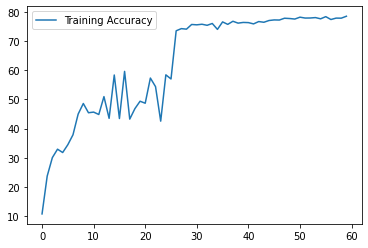

In [31]:
plt.plot(t, label='Training Accuracy')
plt.legend()

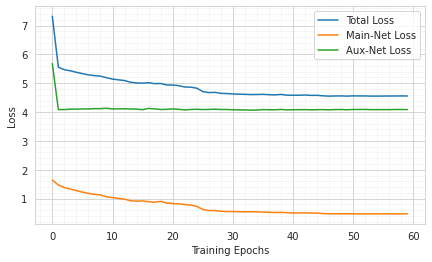

In [40]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize =(7,4))
    plt.plot(LossTrack, label='Total Loss')
    plt.plot(MainTrack, label='Main-Net Loss')          #w - 0.8
    plt.plot(AuxTrack, label='Aux-Net Loss')            #w - 0.2
    plt.legend()
    
    plt.grid(b=True, which='major', linestyle='-')
    plt.grid(b=True, which='minor', linestyle='-', alpha=0.2)
    plt.minorticks_on()
    
    plt.xlabel('Training Epochs')
    plt.ylabel('Loss')
    
    plt.savefig('TrainLoss.pdf')
#p=5,n=3
#test acc - 83.27 
#time - 1121.27 mins

#feature: global best
#shake: No
#Case A: Explotative 
#PSO- Constriction velocity update
#BCE Loss Setup

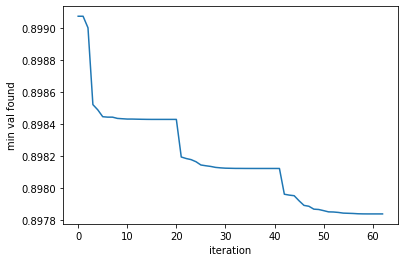

63

In [33]:
PSO_instance.PlotFoundMin()
len(PSO_instance.averageSwarmFitness)                   #63 = 7(blocks) * 3(Feature sizes) * 3(max-iteration)

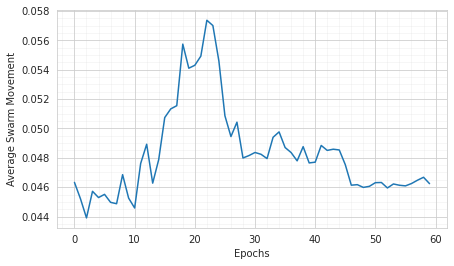

In [39]:
with sns.axes_style("whitegrid"):
    plt.figure(figsize =(7,4))
    
    plt.plot(AvgSwarmMovement)
    plt.xlabel('Epochs')
    plt.ylabel('Average Swarm Movement')

    plt.grid(b=True, which='major', linestyle='-')
    plt.grid(b=True, which='minor', linestyle='-', alpha=0.2)
    plt.minorticks_on()
    
    plt.savefig('AvgMovement.pdf')

In [ ]:
#-------------------------------EXP2---------------------------------------------

plt.plot(t, label='Training Accuracy')
plt.legend()

In [ ]:
plt.plot(LossTrack, label='total Loss')
plt.plot(MainTrack, label='MainNet Loss')     #w=0.8
plt.plot(AuxTrack, label='AuxNet Loss')       #w=0.2
plt.legend()

#p=5,n=3
#test acc - (83.00)
#time - 1069 mins
#ChainMode = 'C'
#BCE loss setup
#Global Best FEATURE INSTEAD OF P_BEST ADDED TO THE MAIN-NET
#Shake: True

In [ ]:
PSO_instance.PlotFoundMin()
len(PSO_instance.averageSwarmFitness)    #63 = 21(layer len)*3(max iter)

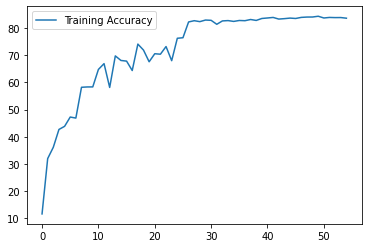

In [24]:
#-------------------------------EXP3---------------------------------------------

plt.plot(t, label='Training Accuracy')
plt.legend()

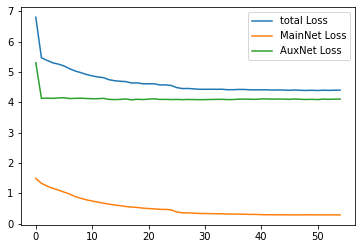

In [25]:
plt.plot(LossTrack, label='total Loss')
plt.plot(MainTrack, label='MainNet Loss')     #w=0.8
plt.plot(AuxTrack, label='AuxNet Loss')       #w=0.2
plt.legend()

#p=5,n=3    
#test acc - (84.29)
#time - 961 mins
#ChainMode = 'A'
#BCE loss setup 
#P_best added to main net

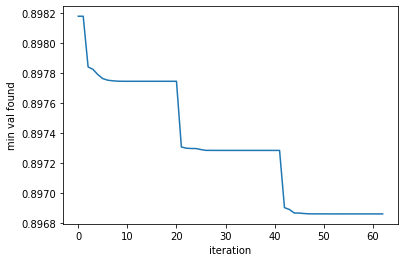

63

In [26]:
PSO_instance.PlotFoundMin()
len(PSO_instance.averageSwarmFitness)    #63 = 21(layer len)*3(max iter)

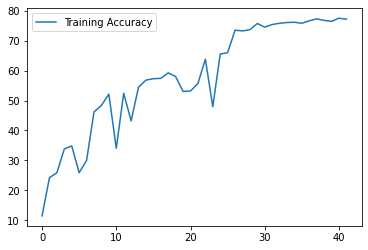

In [27]:
#-------------------------------EXP4---------------------------------------------

plt.plot(t, label='Training Accuracy')
plt.legend()

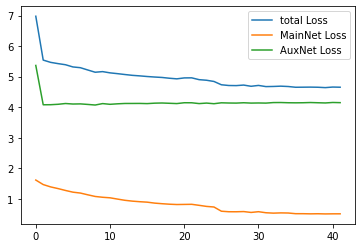

In [28]:
plt.plot(LossTrack, label='total Loss')
plt.plot(MainTrack, label='MainNet Loss')     #w=0.8
plt.plot(AuxTrack, label='AuxNet Loss')       #w=0.2
plt.legend()

#p=5,n=3    
#test acc - (76.67)
#time - 727 mins
#ChainMode = 'A'
#shake: True            #This randomness seems to hinder the learning 
#BCE loss setup 
#P_best added to main net

Text(0, 0.5, 'Average Swarm Movement')

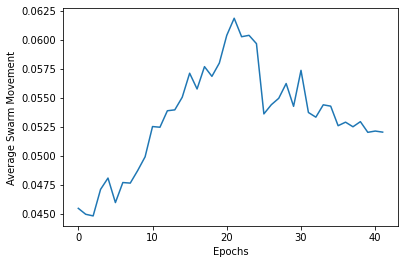

In [32]:
plt.plot(AvgSwarmMovement)
plt.xlabel('Epochs')
plt.ylabel('Average Swarm Movement')

Text(0, 0.5, 'Average Swarm Movement')

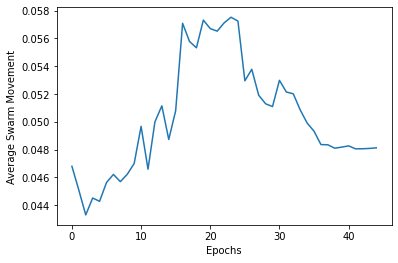

In [28]:
plt.plot(AvgSwarmMovement)
plt.xlabel('Epochs')
plt.ylabel('Average Swarm Movement')

Text(0, 0.5, 'Average Swarm Movement')

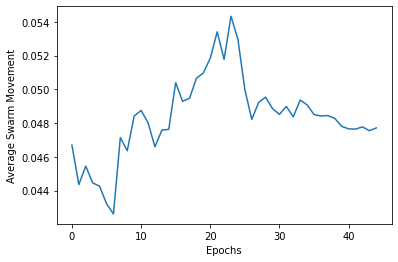

In [26]:
plt.plot(AvgSwarmMovement)
plt.xlabel('Epochs')
plt.ylabel('Average Swarm Movement')

Text(0, 0.5, 'Average Swarm Movement')

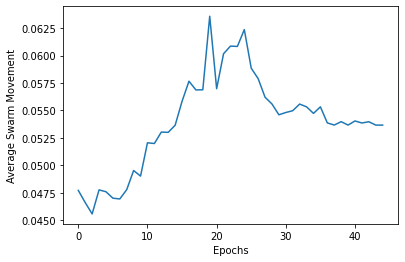

In [56]:
plt.plot(AvgSwarmMovement)
plt.xlabel('Epochs')
plt.ylabel('Average Swarm Movement')

Text(0, 0.5, 'Average Swarm Movement')

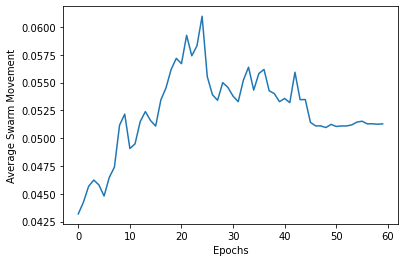

In [118]:
plt.plot(AvgSwarmMovement)
plt.xlabel('Epochs')
plt.ylabel('Average Swarm Movement')

#job schedule = 25,20,15

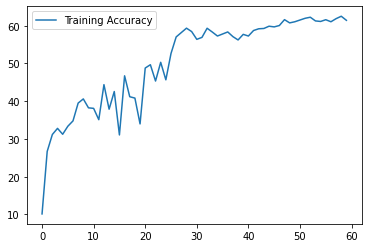

In [29]:
#-------------------------------EXP-N---------------------------------------------

plt.plot(t, label='Training Accuracy')
plt.legend()

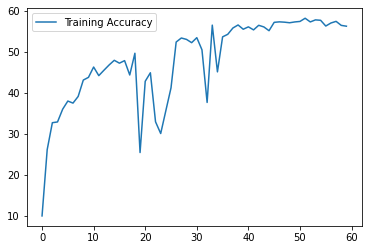

In [56]:
plt.plot(t, label='Training Accuracy')
plt.legend()

#SECOND RUN

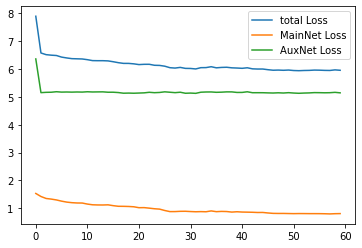

In [30]:
plt.plot(LossTrack, label='total Loss')
plt.plot(MainTrack, label='MainNet Loss')     #w=0.8
plt.plot(AuxTrack, label='AuxNet Loss')       #w=0.2
plt.legend()

#LAYERS = 60*2 Layers (20 blocks each type = 60 blocks)
#p=5,n=3    
#test acc - (59.74)    ||  (57.74)
#time - 2826.40 mins  ~48hrs     ||   2831.28
#ChainMode = 'A'
#BCE loss setup 
#P_best added to main net

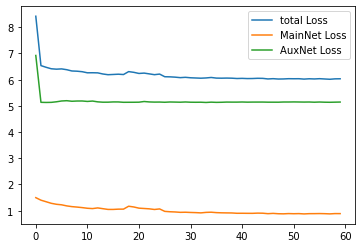

In [59]:
plt.plot(LossTrack, label='total Loss')
plt.plot(MainTrack, label='MainNet Loss')     #w=0.8
plt.plot(AuxTrack, label='AuxNet Loss')       #w=0.2
plt.legend()

#SECOND RUN

Text(0, 0.5, 'Average Swarm Movement')

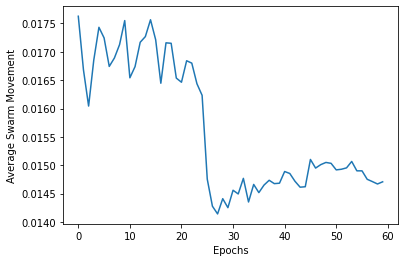

In [31]:
plt.plot(AvgSwarmMovement)
plt.xlabel('Epochs')
plt.ylabel('Average Swarm Movement')

#job schedule = 25,20,15

Text(0, 0.5, 'Average Swarm Movement')

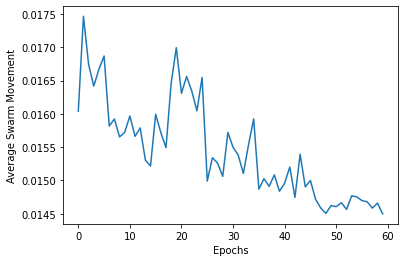

In [55]:
plt.plot(AvgSwarmMovement)
plt.xlabel('Epochs')
plt.ylabel('Average Swarm Movement')

#SECOND RUN
#job schedule = 25,20,15